# The 1D Wave

This example of FDTD in Python will consider the 1D Wave Equation with generic loss is: 

$$
\ddot{u} = c^2 u^{\prime\prime} - 2 \sigma \dot{u}
$$


## Assumptions

This tutorial assumes that you are already familiar with the 1D Wave Equation and its derivation. It also assumes that you have a grasp of [finite difference operators]() and the derivation of the finite difference scheme for the 1D Wave.

If you are not familiar with the above or need a refresher follow the links below

- [1D Wave PDE]()
- [FDTD Operators]()
- [1D Wave FDTD Scheme]()

### Who are you

The assumed audience for this tutorial is someone who is familiar with the baic of python but has never programmed a finite difference scheme before. It is also relevant to those who are familiar with programming a finite difference scheme in MATLAB, but wish to create an implement in python.

## Overview

As a reminder, the finite difference scheme for the 1D wave we are trying to implement is:

$$
\underbrace{(1+\sigma k)(I)}_{A}u^{n}  = \underbrace{(\lambda^2D_{xx} + 2I}_{B})u^{n-1} + \underbrace{(\sigma k - 1)(I)}_{C} u^{n-2} 
$$

$$
\lambda = \frac{ck}{h}; \quad \sigma = \frac{6\log(10)}{T_{60}}
$$

$$
D_{xx} = \begin{bmatrix}
               -2 & 1 & &   \\
               1 & -2 & 1 & \\
                  & \ddots & \ddots & \ddots \\
                  & & 1 & -2
             \end{bmatrix}
$$

with following defintions:

- $n$: the time step index
- $k$: time step for a given _sample rate_
- $\lambda$: the courant number
- $\sigma$: a loss parameter
- $A$, $B$, and $C$: coefficient matrices.

This of course is not the only way we can express the scheme, however a matrix approach will be taken for the remainder of this tutorial. This should hopefully provide a clear connection between the above equation of motion and the actuall programme. The scheme could also be expressed in terms of grid point $l$, which is a perfectly legitmate method and it would be more relevant for a programme that does not take a matrix approach (e.g. C / C++):

$$
u^{n}_{l} = \frac{2u^{n-1}_{l} + (\sigma k - 1)u^{n−2} + \lambda^2(u^{n-1}_{l-1} − 2u^{n-1}_{l} + u^{n-1}_{l+1})}{(1 + \sigma k)}
$$


Any Finite Difference scheme you need to programme can likely be split into the following sections:

1. [Import Libraries](#Import-Libraries)
2. [Parameters](#Parameters)
    - Simluation Parameters
    - Defined Coefficients
    - Derived Coefficients
    - Grid Coefficients
3. [Matrices](#Matrices)
    - Stencil Matrices
    - Coefficient Matrices
    - Time State Vector
    - Input Output Vectors
5. [Simulation](#Simulation)
    - Initial Conditions
    - Main Time Loop

A full version of the script can be found in [Appendex A](#appendix-a). The following breakdown of the script will explore and elaborate on certain choices you might make that would be absent from a final verion.

## Import Libraries

In [1]:
from numpy import pi, log, sqrt, floor, zeros
from scipy import sparse

We have decided here to import only specific functions from `numpy`. This will make some of the code more brief, but also provide more explicit parallels to what you may write in MATLAB / Octave. See [numpy's own style  guide](https://numpydoc.readthedocs.io/en/latest/format.html) when using `numpy` in a larger code base.

`scipy` provides the functionality we need for sparse matrices. The style guide for `scipy` is to simply include the module that is required unlike numpy's `import numpy as np` style.

## Parameters

Next we will define the parameters which will provide our point of entry for interacting with the model.

### Simulation Parameters

The first set of parameters relate to the actual simulation. This section will contain parameters such as sample rate, duration, input and output points.

In [2]:
SR = 44100.0    # sample rate (Hz)
Tf = 0.5        # duration of simulation (s)
xi = 0.8        # coordinate of excitation (normalised, 0 - 1)
xo = 0.1        # coordinate of output (normalised, 0 - 1)

### Coefficients

The next set of parameters are the coefficients, which will be split into three cataegories

- Defined
- Derived
- Grid

#### Defined

Defined coefficients are those which you will give an actual explicit value. In this case we have: 


- `f0`: the fundamental frequency $f_0$
- `r`: the radius of the string in meters
- `L`: the length of the string in meters
- `rho`: the density $\rho$ in $\text{kg m}^{-3}$
- `T60`: the $T_{60}$ decay time


In [3]:
f0  = 440.0   # fundamental frequency (Hz)
r   = 1.27e-4 # string radius (m)
L   = 1.0     # length (m)
rho = 7850    # density (kg/m^3) of steel
T60 = 0.5     # T60 (s)

#### Derived

The next set of coefficients are those which are _derived_ from the previous set.

A definition of tension $T$ based on the $f_0$, _density_, _length_, and _radius_ is included here for easier interaction with the programme.

$$
T =  (2 f_0 L r)^{2}\rho \pi
$$


In [4]:
T = ((2.0 * f0  * L * r) ** 2.0) * rho * pi  # Tension in Newtons
A = pi * (r ** 2.0)         # string cross-sectional area
c = sqrt(T / (rho * A))     # wave speed
sig = 6.0 * log(10.0) / T60 # loss parameter

To demarcate easily between `float` and `int` types it is recommendate to include the `.0` on numbers where the value is intended to be a `float`.


#### Grid

Grid coefficients are those that relate to the FDTD and not the physical model and include variables such as

- `k`: the time step for a given sampling rate
- `hmin`: the minimume grid spacing $h_{\text{min}}$ derived from von Neumann anaylsis
- `N`: number of grid points given a length $L$ and $h_{\text{min}}$
- `h`: an adjusted grid spacing which depends on `N` and which will be used as the grid spacing for the remainder
- `lamb`: the courant number $\lambda$
- `Nf`: The number of time steps in the simulation which is derived from sampling rate and simulation duration $T_f$

In [5]:
k    = 1.0 / SR  # time step
hmin = c * k     # stability condition

N = int(floor(L / hmin))    # number of segments (N+1 is number of grid points)
h = L / N                   # adjusted grid spacing

lamb = c * k / h            # Courant number
Nf   = int(floor(SR * Tf))  # number of time steps

It is important to note that the simulation will not be stable unless $h > h_{\text{min}}$

Both `N` and `Nf` are integers, however the output of [numpy's `floor` function](https://numpy.org/doc/stable/reference/generated/numpy.floor.html) will be `float` given that `L` and `hmin` are `float` type variables. Wrapping the function in `int()` converts the type to integer, which is required when indexing an array.

The variable name `lamb` has been used as [`lambda` is a reserved word in python](https://docs.python.org/3/reference/lexical_analysis.html#keywords).

## Matrices

### Stencil Matrices

For quality of life we can define some stencil matrices so that our calculations are similar to the update equation.

In [6]:
I   = sparse.eye(N)
Dxx = sparse.diags([1, -2, 1], [-1, 0, 1], shape=(N, N))

It is worth noting here that if some boundary conditions were required, then the initialisation of `Dxx` would be a little different. The return format of `sparse.diags` is not fixed. If you need to make further alterations to the stencil, then you may need to [specify a sparse matrix format](https://docs.scipy.org/doc//scipy/reference/sparse.html#sparse-matrix-classes).

### Coefficient Matrices

Reminding ourselves of the scheme:

$$
\underbrace{(1+\sigma k)(I)}_{A}u^{n}  = \underbrace{(\lambda^2D_{xx} + 2I}_{B})u^{n-1} + \underbrace{(\sigma k - 1)(I)}_{C} u^{n-2} 
$$

with the coefficient matrices defined as:

$$
\begin{aligned}
A &= (1+\sigma k)I  \\
B &= \lambda^2D_{xx} + 2I \\
C &=(\sigma k - 1)I \\
\end{aligned}
$$

We can tweak these definitions a little to be

$$
\begin{aligned}
B &= A^{-1}(\lambda^2D_{xx} + 2I) \\
C &= A^{-1}(\sigma k - 1)I \\
\end{aligned}
$$

Given all the ground work that has been done, we can now pretty much just write that.

In [7]:
A = 1.0 / (1.0 + (k * sig))  # inverted
B = A * ((lamb ** 2.0) * Dxx + (2.0 * I))
C = A * ((-1.0 + (k * sig))  * I)

`A` has been pre-inverted here to avoid some uglier formatting.

#### Stencil Shape

It is good practice at this point to have a look at the shape the matrices. This will confirm if you need to make any adjustments or "zero out" any rows or columns in your matrices.

##### B Matrix

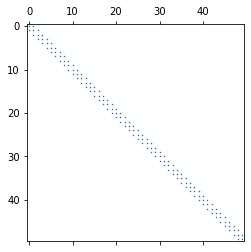

In [8]:
import matplotlib.pyplot as plt

plt.spy(B, markersize=0.5)
plt.show()

##### C Matrix

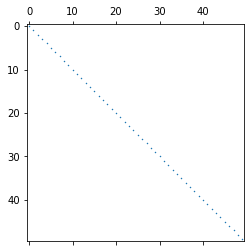

In [9]:
plt.spy(C, markersize = 0.5)
plt.show()

## Time State Vectors

Allocate the correct amount of memory using [numpy's `zeros()` function](https://numpy.org/doc/stable/reference/generated/numpy.zeros.html).

There are only 3 time steps in the scheme. This means we only need 3 vectors which we can swap each time step. The states in our scheme $u^{n}$, $u^{n-1}$, and $u^{n-2}$ can be will be represented by `u0`, `u1`, and `u2` respectively.

In [10]:
u0 = zeros(N)
u1 = zeros(N)
u2 = zeros(N)

### Input / Output

Here we can define our inputs and outputs. We want to get audio output of our simulation so we will need a vector of size `Nf` to hold our sample ouput for each time step. 

We also need to define the grid point the initial condition will be placed, `li`, and the grid point that will be used as the audio "read-out" point, `lo`.

In [11]:
out = zeros(Nf)

li = int(floor(xi * N)) # grid index of excitation
lo = int(floor(xo * N)) # grid index of output

Since `li` and `lo` are indices, we use `int` here to convert the output of `floor`.

## Simulation

### Initial Conditions

The intial condition will be a simple delta.

In [12]:
u1[li] = 1.0

### Main Time Loop

In [13]:
for n in range(Nf):
    u0 = B * u1 + C * u2
    u2, u1, u0 = u1, u0, u2  # state swap
    out[n] = u0[lo]

The update `u0 = B * u1 + C * u2` is pretty close to the original scheme equation.

The second step of swapping the states is a little less intuitive. Here we pack the states into a list on the right hand side:

```py
= u1, u0, u2
```

We can then unpack the same list into the same variables on the left hand side

```py
u2, u1, u0 =
``` 

- `u0 = u2`
- `u2 = u1`
- `u1 = u0`

However if we were to write it this way

```py
u0 = u2 # fine
u2 = u1 # fine
u1 = u0 # uh-oh, this means u1 == u2 !!
```

This is because assigning one `numpy` array variable to another does not copy it as you might expect in MATLAB.

After this we read `u0` at index `lo` and store that as a sample  at index `n` in our audio vector `out`.

### Audio Output

Notebooks provide some functionality to render audio straight to a browser audio player. From here we can listen to our audio output vector `out`.

In [14]:
import IPython.display as ipd

ipd.Audio(data=out, rate=SR)

## Appendix A

For ease the programme explained above is provided in its entirey. Change the parameters in the first section to see what affect they have on the final output.

In [15]:
from numpy import pi, log, sqrt, floor, zeros
from scipy import sparse
import IPython.display as ipd

#---------------------------------------------------------------
# Simulation Parameters
SR = 44100.0    # sample rate (Hz)
Tf = 5.0        # duration of simulation (s)
xi = 0.8        # coordinate of excitation (normalised, 0 - 1)
xo = 0.1        # coordinate of output (normalised, 0 - 1)

# 1D Wave parameters
f0  = 110.0   # fundamental frequency (Hz)
r   = 1.27e-4 # string radius (m)
L   = 1.0     # length (m)
rho = 7850    # density (kg/m^3) of steel
T60 = 7.0     # T60 (s)
#---------------------------------------------------------------
T = ((2.0 * f0  * L * r) ** 2.0) * rho * pi # Tension in Newtons
A = pi * (r ** 2.0)         # string cross-sectional area
c = sqrt( T / (rho * A))    # wave speed
sig = 6.0 * log(10.0) / T60 # loss parameter
#---------------------------------------------------------------
k    = 1.0 / SR # time step
hmin = c * k    # stability condition 

N = int(floor(L / hmin))   # number of segments (N+1 is number of grid points)
h = L / N                  # adjusted grid spacing

lamb = c * k / h           # Courant number
Nf   = int(floor(SR * Tf)) # number of time steps
#---------------------------------------------------------------
I   = sparse.eye(N)
Dxx = sparse.diags([1, -2, 1], [-1, 0, 1], shape=(N, N))

A = 1.0 / (1.0 + (k * sig)) # inverted
B = A * ((lamb ** 2.0) * Dxx + (2.0 * I))
C = A * ((-1.0 + (k * sig))  * I)
#---------------------------------------------------------------
u0  = zeros(N)
u1  = zeros(N)
u2  = zeros(N)

out = zeros(Nf)

li = int(floor(xi * N)) # grid index of excitation
lo = int(floor(xo * N)) # grid index of output
#---------------------------------------------------------------

u1[li] = 1.0

for n in range(Nf):
    u0 = B * u1 + C * u2
    u2, u1, u0 = u1, u0, u2 # state swap
    out[n] = u0[lo]

#---------------------------------------------------------------

ipd.Audio(data=out, rate=SR)